# Rubin TAP + Python Utilities Guide
**Author:** McAelan Remigio

**Based on original material by:** Leanne Guy, Melissa Graham

**Last updated:** June 6, 2025

**Credit:** This simplified guide is derived from the original Rubin Science Platform tutorial by Leanne Guy, created in the context of Rubin DP0.1. It aims to reduce complexity and improve clarity for new learners.

**Disclaimer**: This guide is a simplified adaptation of the Rubin Science Platform tutorial originally developed by Leanne Guy and Melissa Graham. It preserves much of the original structure and content, with modifications for clarity and beginner accessibility.

This guide dives into TAP service and basic ADQL queries through:

**TAP Glossary**

schema - storage of data in database

tap_schema - tables describing data tables + columns

table - collection of related data in a table format in a database, can be found in object files 

query - string formatted in ADQL to select certain data from a table


**ADQL Syntax**

`<columns>` - comma-separated list of columns

`<catalog>` is the name of the catalog to retreive data from

`<constraints>` imposes a restriction that only rows with column values that meet the constraints are returned.

SELECT - what column(s) you want to retrieve

FROM - what table(s) you're querying

WHERE - filter rows (example: "WHERE mag < 15" to find only stars with magnitude less than 15")

TOP - limit the number of results (example: "TOP 100" will limit your return to 100 results)

AS - rename columns or tables (aliases)

AND - filter out rows that meet multiple conditions at the same time, ALL conditions must be true

OR - filters out rows that meet at least one of the multiple conditions to be true

NOT - negates a condition, use when you want to exclude rows that meet a certain condition

ORDER BY column ASC - sorts by ascending (smallest to largest), remember that smaller mags = brighter stars so asc will sort from brightest to faintest

ORDER BY column DESC - sorts by descending (largest to smallest)

NOTE: do NOT use SELECT * FROM mysurveydata, Rubin Science Platform catalogs are insanely large (MILLIONS OF ROWS), using this ADQL statement will attempt to run the entire table.

**TAP Queries Recommendations**

1) Use synchronous queries (no other cells can be run aside from this one) ( results = service.search(query) ) when dealing with schema or small amounts, but use asynchronous queries ( job = service.submit_job(query) ) when retrieving larger amounts of data (can be run in the background while you run other code cells) 

2) Include coordinate constraints (like a cone search) when possible since its faster than ADQL query statmements

3) detect_isPrimary = True constraint, only remove this if you want duplicate results

4) Use TOP to limit rows, not maxrec, and only use TOP with ORDER BY if the query's WHERE statements significantly cut down the number of objects that need to be sorted

In [16]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.visualization.wcsaxes import SphericalCircle
from lsst.rsp import get_tap_service, retrieve_query

service = get_tap_service("tap")
assert service is not None

In [17]:
# Generally when you run pandas it'll show a certain number of rows, this sets the maximum number of rows you want to see
pandas.set_option('display.max_rows', 10)

In [18]:
# ADQL Query selecting all columns from tap_schema to revel all available catalogs
query = 'SELECT * FROM tap_schema.schemas'

# executing the query by passing it to the TAP search method and storing it in results
results = service.search(query)
print(type(results))

# the result is TAPResults which is a python class from the PyVO Data Access package

# more convnient to convert results into Astropy table 
results_table = results.to_table()
print(type(results_table))
results_table

<class 'pyvo.dal.tap.TAPResults'>
<class 'astropy.table.table.Table'>


description,schema_index,schema_name,utype
object,int32,object,object
"Data Preview 0.2 contains the image and catalog products of the Rubin Science Pipelines v23 processing of the DESC Data Challenge 2 simulation, which covered 300 square degrees of the wide-fast-deep LSST survey region over 5 years.",0,dp02_dc2_catalogs,
ObsCore v1.1 attributes in ObsTAP realization,1,ivoa,
A TAP-standard-mandated schema to describe tablesets in a TAP 1.1 service,100000,tap_schema,


In [19]:
# A for loop will start at one point and continuously iterate through the data given that it satisifies the conditions
# and will keep on going until it is told to stop or until it reaches the end. 

# in this case we are looking for the presence of dp02 in the schema_name column so we can see if we have dp02 in our results table
for name in results_table['schema_name']:
    if name.find('dp02') > -1:
        print(name)

dp02_dc2_catalogs


In [20]:
# clean up by deleting query and results
del query, results, results_table

In [27]:
# A query that selects all columns from a certain table for a catalog schema to return the names of all tables available in said catalog
# in this case, all tables available in dp02_dc2_catalogs

query = "SELECT * FROM tap_schema.tables " \
        "WHERE tap_schema.tables.schema_name = 'dp02_dc2_catalogs'" \
        "ORDER BY table_index ASC"
results = service.search(query).to_table()
results

description,schema_name,table_index,table_name,table_type,utype
object,object,int32,object,object,object
Properties of the astronomical objects detected and measured on the deep coadded images.,dp02_dc2_catalogs,1,dp02_dc2_catalogs.Object,table,
"Properties of detections on the single-epoch visit images, performed independently of the Object detections on coadded images.",dp02_dc2_catalogs,2,dp02_dc2_catalogs.Source,table,
"Forced-photometry measurements on individual single-epoch visit images and difference images, based on and linked to the entries in the Object table. Point-source PSF photometry is performed, based on coordinates from a reference band chosen for each Object and reported in the Object.refBand column.",dp02_dc2_catalogs,3,dp02_dc2_catalogs.ForcedSource,table,
Properties of time-varying astronomical objects based on association of data from one or more spatially-related DiaSource detections on individual single-epoch difference images.,dp02_dc2_catalogs,4,dp02_dc2_catalogs.DiaObject,table,
Properties of transient-object detections on the single-epoch difference images.,dp02_dc2_catalogs,5,dp02_dc2_catalogs.DiaSource,table,
"Point-source forced-photometry measurements on individual single-epoch visit images and difference images, based on and linked to the entries in the DiaObject table.",dp02_dc2_catalogs,6,dp02_dc2_catalogs.ForcedSourceOnDiaObject,table,
"Metadata about the pointings of the DC2 simulated survey, largely associated with the boresight of the entire focal plane.",dp02_dc2_catalogs,7,dp02_dc2_catalogs.Visit,table,
Metadata about the 189 individual CCD images for each Visit in the DC2 simulated survey.,dp02_dc2_catalogs,8,dp02_dc2_catalogs.CcdVisit,table,
Static information about the subset of tracts and patches from the standard LSST skymap that apply to coadds in these catalogs,dp02_dc2_catalogs,9,dp02_dc2_catalogs.CoaddPatches,table,


In [28]:
del query, results # for cleanup, good practice to reset your queries

In [29]:
# list all columns in object table, store in astropy table
query = "SELECT column_name, datatype, description, unit " \
        "FROM tap_schema.columns " \
        "WHERE table_name = 'dp02_dc2_catalogs.Object'"
results = service.search(query).to_table()
results

column_name,datatype,description,unit
object,object,object,object
coord_dec,double,Fiducial ICRS Declination of centroid used for database indexing,deg
coord_ra,double,Fiducial ICRS Right Ascension of centroid used for database indexing,deg
deblend_nChild,int,Number of children this object has (defaults to 0),
deblend_skipped,boolean,Deblender skipped this source,
detect_fromBlend,boolean,This source is deblended from a parent with more than one child.,
detect_isDeblendedModelSource,boolean,True if source has no children and is in the inner region of a coadd patch and is in the inner region of a coadd tract and is not a sky source and is a deblended child,
detect_isDeblendedSource,boolean,True if source has no children and is in the inner region of a coadd patch and is in the inner region of a coadd tract and is not a sky source and is either an unblended isolated source or a deblended child from a parent with,
detect_isIsolated,boolean,This source is not a part of a blend.,
detect_isPatchInner,boolean,True if source is in the inner region of a coadd patch,


In [30]:
# the "..." that appears in the middle of the table means its too long and that there are too many columns to read through
# to fix this, you can use a for loop to only return results that have the match you're looking for 

# in this case, a for loop to look for "coord" in column_name, and writing the name down when there is a match
search_string = 'coord'
for cname in results['column_name']:
    if cname.find(search_string) > -1:
        print(cname)

coord_dec
coord_ra


In [32]:
search_string = 'g_psfFlux'
for cname in results['column_name']:
    if cname.find(search_string) > -1:
        print(cname)

# flag values mean that there's warnings meaning that they're most likely missing some flux

# datatype and units column has a limited set of values 
print(np.unique(results['datatype']))
print(np.unique(results['unit']))

g_psfFlux
g_psfFlux_area
g_psfFlux_flag
g_psfFlux_flag_apCorr
g_psfFlux_flag_edge
g_psfFlux_flag_noGoodPixels
g_psfFluxErr
datatype
--------
 boolean
    char
  double
   float
     int
    long
  unit  
--------
        
     deg
     nJy
   pixel
pixel**2


In [33]:
del query, results

**Asynchronous Queries**

Can run in background while running other cells until it completes and results can be rerieved right away or at a later time. Queries in our datasets are more complex so retrieving rows of data (not just schema) uses asynchronous queries more often.

Cone Search

A cone search means a catalog query that returns all objects within a given radius of a sky coordinate. Since a given angular diameter corresponds to a larger physical diameter at larger distances, the volume queried is a cone, not a cylinder.

In ADQL, a cone search is executed with `WHERE CONTAINS(POINT(), CIRCLE()) = 1`.
 * `POINT()` passes the catalog's columns for sky coordinates.
 * `CIRCLE()` defines the center and radius of the search circle.
 * `CONTAINS() = 1` constrains the query to only return rows for which the statement "this circle contains this point" is "True" (=1).

In [38]:
# define center coord and radius + TAP queries created as strings 

center_ra = 62
center_dec = -37
radius = 0.01

str_center_coords = str(center_ra) + ", " + str(center_dec)
str_radius = str(radius)

query = "SELECT coord_ra, coord_dec "\
        "FROM dp02_dc2_catalogs.Object "\
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "\
        "CIRCLE('ICRS', " + str_center_coords + ", " + str_radius + ")) = 1 "\
        "AND detect_isPrimary = 1"
print(query)

# Submitting query 
job = service.submit_job(query)
print('Job URL is', job.url)
print('Job phase is', job.phase)

SELECT coord_ra, coord_dec FROM dp02_dc2_catalogs.Object WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), CIRCLE('ICRS', 62, -37, 0.01)) = 1 AND detect_isPrimary = 1
Job URL is https://data.lsst.cloud/api/tap/async/w8yoefvz0t8k83r7
Job phase is PENDING


In [39]:
job.run()
# wait for job status will either say "COMPLETED" or "ERROR", not mandatory but helpful in letting you know when the job is no longer
# running, but note that THIS next cell is synchronous, not asynchronous.

In [40]:
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


In [41]:
# If the status was returned was COMPLETED, execute these lines to retrieve the query results as an astropy table and print the
# length of the table
results = job.fetch_result().to_table()
print(len(results))
results

# If the status was returned was ERROR, uncomment this and execute this cell top print the error messages 
# job.raise_if_error()


173


coord_ra,coord_dec
deg,deg
float64,float64
61.9892581,-37.0051185
61.9974384,-37.0057962
62.0032855,-37.0062479
61.9982376,-37.0071231
62.0033408,-37.0025362
62.0087858,-37.0048004
62.0067606,-37.008115
61.9996415,-37.0073422


Plotting Coordinates Right Ascension (RA) vs Declination (Dec)

In this example we will shade the query region using the astropy clsas SphericalCircle

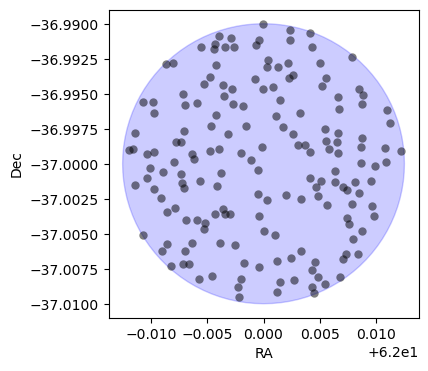

In [42]:
fig = plt.figure(figsize=(4, 4))

region = SphericalCircle((center_ra * u.deg, center_dec * u.deg),
                         radius * u.deg, alpha=0.2, color='blue')
plt.gca().add_patch(region)

plt.plot(results['coord_ra'], results['coord_dec'],
         'o', alpha=0.5, color='black', mew=0)

plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

RA vs Dec coordinates for Objects are retrieved by the query (black dots) within the query region (purple circle)

In [43]:
# clean up and save memory
job.delete()
del query, results

Limiting Rows Returned w/ TOP

For debugging and testing queries, can be faster if only retrieving a subset of rows meeting query constraints

In [51]:
N = 20
query = "SELECT TOP " + str(N) + " coord_ra, coord_dec "\
        "FROM dp02_dc2_catalogs.Object "\
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "\
        "CIRCLE('ICRS', " + str_center_coords + ", " + str_radius + ")) = 1 "\
        "AND detect_isPrimary = 1"
print(query)

SELECT TOP 20 coord_ra, coord_dec FROM dp02_dc2_catalogs.Object WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), CIRCLE('ICRS', 62, -37, 0.01)) = 1 AND detect_isPrimary = 1


In [52]:
# Asynchronous job 
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

results = job.fetch_result().to_table()
print(len(results))

Job phase is COMPLETED
20


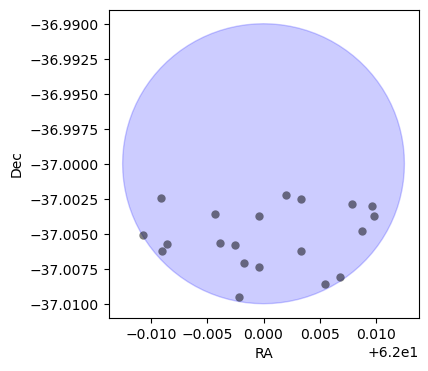

In [53]:
fig = plt.figure(figsize=(4, 4))
region = SphericalCircle((center_ra * u.deg, center_dec * u.deg),
                         radius * u.deg, alpha=0.2, color='blue')
plt.gca().add_patch(region)
plt.plot(results['coord_ra'], results['coord_dec'],
         'o', alpha=0.5, color='black', mew=0)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

Only the top 20 objects of RA vs Dec coordinates for Objects are retrieved by the query (black dots) within the query region (purple circle), all black dorts are located in the lower half of the blue circle 

In [54]:
# Clean up
job.delete()
del query, results

Use of maxrec instead of TOP if you want to test a large query without pulling full results and don't want to modify the original query, or if in this case, the Rubin Science Platform, lets you limit result size externally. 

In [55]:
query = "SELECT coord_ra, coord_dec "\
        "FROM dp02_dc2_catalogs.Object "\
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "\
        "CIRCLE('ICRS', " + str_center_coords + ", " + str_radius + ")) = 1 "\
        "AND detect_isPrimary = 1"
print(query)

SELECT coord_ra, coord_dec FROM dp02_dc2_catalogs.Object WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), CIRCLE('ICRS', 62, -37, 0.01)) = 1 AND detect_isPrimary = 1


In [57]:
job = service.submit_job(query, maxrec=N)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


In [58]:
results = job.fetch_result().to_table()
print(len(results))

# in this case, you can get a DALOverflowingWarning qhen results are retrieved, meaning that partial results were returned.
# it is okay here though because our intent was to return partial results by using maxrec instead of TOP 

20


/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pyvo/dal/query.py:341: DALOverflowWarning: Partial result set. Potential causes MAXREC, async storage space, etc.
  warn("Partial result set. Potential causes MAXREC, async storage space, etc.",


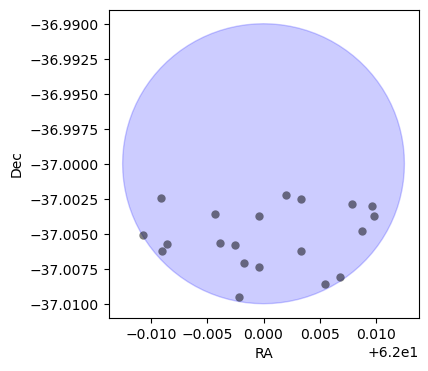

In [59]:
fig = plt.figure(figsize=(4, 4))
region = SphericalCircle((center_ra * u.deg, center_dec * u.deg),
                         radius * u.deg, alpha=0.2, color='blue')
plt.gca().add_patch(region)
plt.plot(results['coord_ra'], results['coord_dec'],
         'o', alpha=0.5, color='black', mew=0)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

# same as the figure from above 

In [60]:
job.delete()
del query, results

Sorting results by ORDER BY 

Note: Use ORDER BY and TOP together with caution, since if the query is not well constrained, you may end up sorting before returning the TOP numbers which is inefficient with time and resources 

Query that returns the TOP N objects sorted by coord_ra in ascending (ASC) order

In [61]:
query = "SELECT TOP " + str(N) + " coord_ra, coord_dec "\
        "FROM dp02_dc2_catalogs.Object "\
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "\
        "CIRCLE('ICRS', " + str_center_coords + ", " + str_radius + ")) = 1 "\
        "AND detect_isPrimary = 1 "\
        "ORDER BY coord_ra ASC"
print(query)

SELECT TOP 20 coord_ra, coord_dec FROM dp02_dc2_catalogs.Object WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), CIRCLE('ICRS', 62, -37, 0.01)) = 1 AND detect_isPrimary = 1 ORDER BY coord_ra ASC


In [64]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

results = job.fetch_result().to_table()
print(len(results))

Job phase is COMPLETED
20


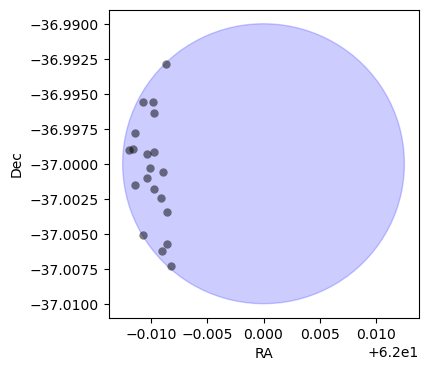

In [65]:
fig = plt.figure(figsize=(4, 4))
region = SphericalCircle((center_ra * u.deg, center_dec * u.deg),
                         radius * u.deg, alpha=0.2, color='blue')
plt.gca().add_patch(region)
plt.plot(results['coord_ra'], results['coord_dec'],
         'o', alpha=0.5, color='black', mew=0)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

The top 20 Objects returned (black dots) are all on the left-most edge of the purple circle because they have the lowest RA values and query resulrs were sorted by RA in ascending order before the top 20 were selected.

In [66]:
# clean up
job.delete()
del query, results

Sorting Results with Pandas


In [ ]:
# same query for a small unsorted set of Objects

In [67]:
query = "SELECT coord_ra, coord_dec "\
        "FROM dp02_dc2_catalogs.Object "\
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "\
        "CIRCLE('ICRS', " + str_center_coords + ", " + str_radius + ")) = 1 "\
        "AND detect_isPrimary = 1"
print(query)

SELECT coord_ra, coord_dec FROM dp02_dc2_catalogs.Object WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), CIRCLE('ICRS', 62, -37, 0.01)) = 1 AND detect_isPrimary = 1


In [68]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


In [70]:
# retrieving results and converting results to a pandas dataframe
results = job.fetch_result().to_table().to_pandas()
print(len(results))
print(type(results)) # should return .DataFrame
results # should return a DataFrame

173
<class 'pandas.core.frame.DataFrame'>


,coord_ra,coord_dec
0,61.989258,-37.005119
1,61.997438,-37.005796
2,62.003285,-37.006248
3,61.998238,-37.007123
4,62.003341,-37.002536
...,...,...
168,61.990251,-36.996347
169,61.989260,-36.995563
170,61.990184,-36.995566
171,61.992685,-36.998426


In [71]:
# sorting 
sorted_results = results.sort_values('coord_ra')
sorted_results.set_index(np.array(range(len(sorted_results))), inplace=True) # do this because it will reset the index of the 
# sorted_results dataframe
sorted_results

,coord_ra,coord_dec
0,61.988079,-36.999024
1,61.988408,-36.998968
2,61.988546,-36.997821
3,61.988612,-37.001517
4,61.989258,-37.005119
...,...,...
168,62.010771,-36.998845
169,62.010843,-36.999844
170,62.010987,-36.996173
171,62.011207,-36.997063


In [72]:
# clean up
job.delete()
del query, results, sorted_results

**Retrieving Query Results with job URL**

Job results are generally available from previously run queries, and can be retrieved if the URL of the job is known _and_ if the job
has not been deleted.

Do not use `job.delete()` if the results will be retrieved later!

In [73]:
query = "SELECT coord_ra, coord_dec "\
        "FROM dp02_dc2_catalogs.Object "\
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "\
        "CIRCLE('ICRS', " + str_center_coords + ", " + str_radius + ")) = 1 "\
        "AND detect_isPrimary = 1"
print(query)

job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

SELECT coord_ra, coord_dec FROM dp02_dc2_catalogs.Object WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), CIRCLE('ICRS', 62, -37, 0.01)) = 1 AND detect_isPrimary = 1
Job phase is COMPLETED


In [75]:
# instead of using job.fetch_result(), store the job.url and print it, that URl cvan be used to retrieve the query results,
# shared with another user of Rubin TAP Service, and can retrieve the same results
my_job_url = str(job.url)
print(my_job_url)

retrieved_job = retrieve_query(my_job_url)
retrieved_results = retrieved_job.fetch_result().to_table().to_pandas()
retrieved_results

https://data.lsst.cloud/api/tap/async/rz9zz0ym9tkmjrh7


,coord_ra,coord_dec
0,61.989258,-37.005119
1,61.997438,-37.005796
2,62.003285,-37.006248
3,61.998238,-37.007123
4,62.003341,-37.002536
...,...,...
168,61.990251,-36.996347
169,61.989260,-36.995563
170,61.990184,-36.995566
171,61.992685,-36.998426


In [76]:
# clean up
job.delete()
del query, retrieved_results

We are working in RSP Notebooks, but you can also run this from the portal 

In a new browser tab, go to <a href="https://data.lsst.cloud/">data.lsst.cloud</a> and enter the Portal Aspect.

Click on the tab "DP0.2 Catalogs" at the top of the screen.

Click "Edit ADQL" at upper right.

Copy-paste the following query into the ADQL box as shown in the screenshot below.

```
SELECT coord_ra, coord_dec FROM dp02_dc2_catalogs.Object
WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), CIRCLE('ICRS', 62, -37, 0.01)) = 1
AND detect_isPrimary = 1
```

The default results view will appear in the results tab 

The search results have been automatically saved and assigned a URL.

Click on the "Info" button (the letter i in a circle),
which is in the upper right-hand corner of the table (bottom of the screen).

The pop-up window contains the URL (the Job Link).

In [ ]:
# to create a new URL, for example, the results of the portal query in the notebook here

In [ ]:
# my_portal_url = ''
# retrieved_job = retrieve_query(my_portal_url)
# retrieved_results = retrieved_job.fetch_result().to_table().to_pandas()
# retrieved_results

In [ ]:
# retrieved_job.delete()
# del retrieved_results